In [34]:
colorscale=[    
    [0.0               ,'rgb(204,204,204)', ],   
    [0.0111111111111111,'rgb(56,217,113)', ],   
    [0.1111111111111111,'rgb(250,135,117)', ],   
    [0.2222222222222222,'rgb(255,215,0)', ],   
    [0.2555555555555555,'rgb(87,215,222)',  ],    
    [0.3333333333333333,'rgb(205,52,181)', ],  
    [0.4444444444444444,'rgb(0,0,255)', ],  
    [0.5555555555555556,'rgb(231,58,52)', ],   
    [0.6666666666666666,'rgb(157,2,215)', ],   
    [0.7777777777777778,'rgb(118,245,60)',  ],   
    [0.8888888888888888,'rgb(234,95,148)',  ],   
    [1.0               ,'rgb(255,177,78)'  ]]

In [35]:
colorscale =[ 
            [0.0                 ,  '#cecece',], 
            [0.047619047619047616,  '#ffff00',],
            [0.09523809523809523 ,  '#fff21d',],
            [0.14285714285714285 ,  '#ffe52a',],
            [0.19047619047619047 ,  '#ffd733',],
            [0.23809523809523808 ,  '#ffca3a',],
            [0.2857142857142857  ,  '#ffbd40',],
            [0.3333333333333333  ,  '#ffad45',],
            [0.38095238095238093 ,  '#ffa049',],
            [0.42857142857142855 ,  '#ff904d',],
            [0.47619047619047616 ,  '#ff7f50',],
            [0.5238095238095237  ,  '#ff7f50',],
            [0.5714285714285714  ,  '#f47263',],
            [0.6190476190476191  ,  '#e96673',],
            [0.6666666666666667  ,  '#dd5a83',],
            [0.7142857142857144  ,  '#cf4d92',],
            [0.7619047619047621  ,  '#c040a1',],
            [0.8095238095238098  ,  '#b033af',],
            [0.8571428571428574  ,  '#9e25be',],
            [0.9047619047619051  ,  '#8615cd',],
            [0.9523809523809528  ,  '#6900db',], 
            [1                   ,  '#3d3d3d']]

## Funciondes de ploteo y análisis
- https://projects.susielu.com/viz-palette?colors=[%22#cccccc%22,%22#38d971%22,%22#fa8775%22,%22#ffd700%22,%22#57d7de%22,%22#cd34b5%22,%22#0000ff%22,%22#e73a34%22,%22#9d02d7%22,%22#76f53c%22,%22#ea5f94%22,%22#ffb14e%22]&backgroundColor=%22#1d163d%22&fontColor=%22black%22


In [36]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
## Silhouette  test
#Determina el numero optimo de clusters
def test_silueta(df): 

    rango_vecinos=[]
    num_clusters = []
    silueta = []
    calinski = []
    bouldin = []
    sse = [] # for kmeans.inertia_

    X = np.array(df)  
    # Estandarización
    #scaler = StandardScaler().fit(X)
    #X = scaler.transform(X)

    for n in range( 1 , 700 ) :  
        model = hdbscan.HDBSCAN(min_cluster_size=n+1 ).fit(X) 
        labels = model.labels_
        n_clusters_ = len(set(labels )) - (1 if -1 in labels  else 0)
        #n=n-50
        if n_clusters_!= 0 :
            rango_vecinos.append(n+1)
            num_clusters.append( n_clusters_ )
            
            s = 0
            c = 0
            b = 0  
            
            # para saltar un test comentar linea
            s = metrics.silhouette_score( X , labels )
            #c = metrics.calinski_harabaz_score(X , labels)
            #b = metrics.davies_bouldin_score(X , labels)
             
            silueta.append(s) 
            calinski.append(c)
            bouldin.append(b) 
            
            print(str(n)+ 'mpts:'+str(n+1)+' Silueta: '+str(round(s , 2 )))
             
        else:
            continue;
         
    bench_df = pd.DataFrame({
        "num_vecinos":rango_vecinos,
        "num_clusters": num_clusters, 
        "silueta":silueta,
        'calinski':calinski,  
        'bouldin':bouldin
    } )  
    bench_df.to_csv('bench.csv', sep=';' , index=False , decimal = ',')
    return  bench_df

In [38]:
# scatter  
def scatter(x_pos ,y_pos): 
    ## solo va a funcionar se existe se corrio hdbscan
    trace = go.Scatter(
        x = X[:, x_pos],   
        y = X[:, y_pos],   
        mode = 'markers', 
        text=labels_  ,
        marker=dict(color = labels_ ,
                    colorscale=colorscale)
    ) 
    layout = go.Layout(
        #title='Segmentación de clientes HDBSCAN '+str(registros)+' Registros'+' '+str(n_clusters_)+' Clusters' ,
        
        title='[Registros:'+str(registros)+']'+
          '[mpts:' +str(mpts)+']'+
          '[Clusters:' +str(n_clusters_)+']'+
          '[Silueta:'  +str(round(coef_s , 2))+']'+
          '[Calinski:' +str(round(coef_c , 2))+']'+
          '[Bouldin:'  +str(round(coef_b , 2))+']',
        
        
        plot_bgcolor = '#FFFFFF',
        paper_bgcolor = '#FFFFFF', 
        xaxis=dict(
                title=sample.columns[x_pos] 
            ),
            yaxis=dict(
                title=sample.columns[y_pos]
            ) 
    )
    data = [trace] 
    fig = go.Figure(data = data, layout = layout)
    # Plot and embed in ipython notebook!
    return fig 
#py.iplot(fig ,   filename='scatter_hdbscan')


In [39]:
def ploty_scatter(x , y ):
    # Create a trace
    trace = go.Scatter(
        x = x,   
        y = y,   
        mode = 'markers', 
        marker=dict(colorscale=colorscale ) 
    ) 
    layout = go.Layout( 
        plot_bgcolor = '#FFFFFF',
        paper_bgcolor = '#FFFFFF' 
    )
    data = [trace] 
    fig = go.Figure(data = data, layout = layout)
    # Plot and embed in ipython notebook!
    #py.iplot(fig ,   filename='simple_scatter') 
    return fig 

In [40]:
def caja(df):
    trace0 = go.Box(
        y=df
    ) 
    data = [trace0 ] 
    fig = go.Figure(data = data )  
    return fig
     
#fig = caja(sample['FACTURACION_PROMEDIO'])
#py.iplot(fig ,   filename='caja') 

In [41]:
def plot_test( df ): 
     
    # 'num_vecinos', 'num_clusters', 'silueta', 'calinski', 'bouldin'
    x = df.index
    
    trace1 = go.Scatter(
        x=x,
        y=df.silueta,
        name='Silueta',
        mode='lines+markers'
    )
    trace2 = go.Scatter(
        x=x,
        y=df.calinski,
        name='Calinski',
        yaxis='y2',
        mode='lines+markers'
    )
    trace3 = go.Scatter(
        x=x,
        y=df.bouldin,
        name='Bouldin',
        yaxis='y3',
        mode='lines+markers'
    )
    trace4 = go.Scatter(
        x=x,
        y=df.num_clusters,
        name='Clusters',
        yaxis='y4',
        mode='lines+markers'
    )
    trace5 = go.Scatter(
        x=x,
        y=df.num_vecinos,
        name='mpts',
        yaxis='y5',
        mode='lines+markers'
    )
    
    data = [trace1, trace2, trace3 ,  trace4  , trace5]
    
    layout = go.Layout(
        title='Testing',
        width=900, 
        yaxis=dict(
            title='Silueta',
            titlefont=dict(
                color='#1f77b4'
            ),
            tickfont=dict(
                color='#1f77b4'
            )
        ),
        yaxis2=dict(
            title='Calinski',
            titlefont=dict(
                color='#ff7f0e'
            ),
            tickfont=dict(
                color='#ff7f0e'
            ),
            anchor='free',
            overlaying='y',
            side='left',
            position=0.15
        ),
        yaxis3=dict(
            title='Bouldin',
            titlefont=dict(
                color='#d62728'
            ),
            tickfont=dict(
                color='#d62728'
            ),
            anchor='x',
            overlaying='y',
            side='right'
        ),
        yaxis4=dict(
            title='Clusters',
            titlefont=dict(
                color='#fc3737'
            ),
            tickfont=dict(
                color='#fc3737'
            ),
            anchor='free',
            overlaying='y',
            side='right',
            position=0.85
        ),
        yaxis5=dict(
            title='Mpts',
            titlefont=dict(
                color='#42f4d4'
            ),
            tickfont=dict(
                color='#42f4d4'
            ),
            anchor='free',
            overlaying='y',
            side='right',
            position=0.65
        )
    )
    fig = go.Figure(data=data, layout=layout)
    #plot_url = py.plot(fig, filename='multiple-axes-multiple')
    return fig  

In [42]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.plotly as py
import plotly.graph_objs as go 
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min 
from sklearn.preprocessing import StandardScaler 
from sklearn import metrics 
from sklearn.metrics import davies_bouldin_score 
import hdbscan 

#plotly.tools.set_credentials_file(username='slotbite', api_key='GYgRt3eXz6IdiIy3k7sO')
py.plotly.tools.set_credentials_file(username='cachulooo', api_key='srvpWbqoQ27WdGO3pArx')

 
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)

In [43]:
# Cargando datos
df = pd.read_csv("segmentacion_clientes.csv" , delimiter=";" , decimal="," , encoding='utf-8')

In [44]:
#df=data

In [45]:
#sample=df
#sample = df[(sample.QUEJAS==2)] 
#plt.xticks(rotation=90)
#sample.groupby('COMUNA').size().sort_values(ascending=False) 

## Muestreo de distrubuciones

```
sample=df
#sample = df[(sample.QUEJAS==2) ] 
plt.xticks(rotation=90)
plt.plot(sample.groupby('QUEJAS').size().sort_values(ascending=False))
```

## Categorización <br> Encodificación <br> Estandarización

In [46]:
# Eliminacion de outliers (-)
df = df[df.PRODUCT_ID > 0] 
df = df[(df.FACTURACION_PROMEDIO > 0 ) & (df.FACTURACION_PROMEDIO <= 397000 )] 
df = df[(df.SALDO_PROMEDIO > 0 ) & (df.SALDO_PROMEDIO <= 401500 )]  


## Convertimos las variables categoricas
#http://pbpython.com/categorical-encoding.html
pd.options.mode.chained_assignment = None
df["COMUNA"] = df["COMUNA"].astype('category')
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].astype('category')
df["TI"] = df["TI"].astype('category')
df["TI2"] = df["TI2"].astype('category')

# luego la encodificamos 
df["TI"] = df["TI"].cat.codes
df["TI2"] = df["TI2"].cat.codes
df["COMUNA_ENC"] = df["COMUNA"].cat.codes 
df["TIPO_REPARTO"] = df["TIPO_REPARTO"].cat.codes 
df[:3]

,PRODUCT_ID,SUBSCRIPTION_ID,SUBSCRIBER_ID,COMUNA,TI,TI2,TIPO_REPARTO,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC
0,122551,122551,13185036,128 - San Esteban ...,0,0,0,0,0,0,0,18964.8333,33256.6667,1.753504,8
1,122581,122581,122581,128 - San Esteban ...,0,0,0,0,0,0,0,28445.7500,36605.0833,1.286793,8
2,109938,109938,3665521,145 - San Felipe ...,0,1,0,0,0,1,0,135045.4170,327823.5000,2.427488,18


In [47]:
df.columns

Index(['PRODUCT_ID', 'SUBSCRIPTION_ID', 'SUBSCRIBER_ID', 'COMUNA', 'TI', 'TI2',
       'TIPO_REPARTO', 'QUEJAS', 'DAÑOS', 'CORTES', 'RECLAMOS',
       'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO', 'ROTACION_CARTERA',
       'COMUNA_ENC'],
      dtype='object')

## Correlacion de variables 

In [48]:
## SELECCION PARA NUMERO DE QUEJAS 9  
features=[ 'PRODUCT_ID', 'QUEJAS', 'DAÑOS',
            'CORTES', 'RECLAMOS','FACTURACION_PROMEDIO',
            'SALDO_PROMEDIO', 'ROTACION_CARTERA' ,
           'COMUNA_ENC' , 'TI' , 'TI2' ,'TIPO_REPARTO']
 
# selecciono el intervalo a trabajar 
#df = df[(df.QUEJAS==9)] 
 
# seleccion de variables a trabajar 
sample = df[features] 

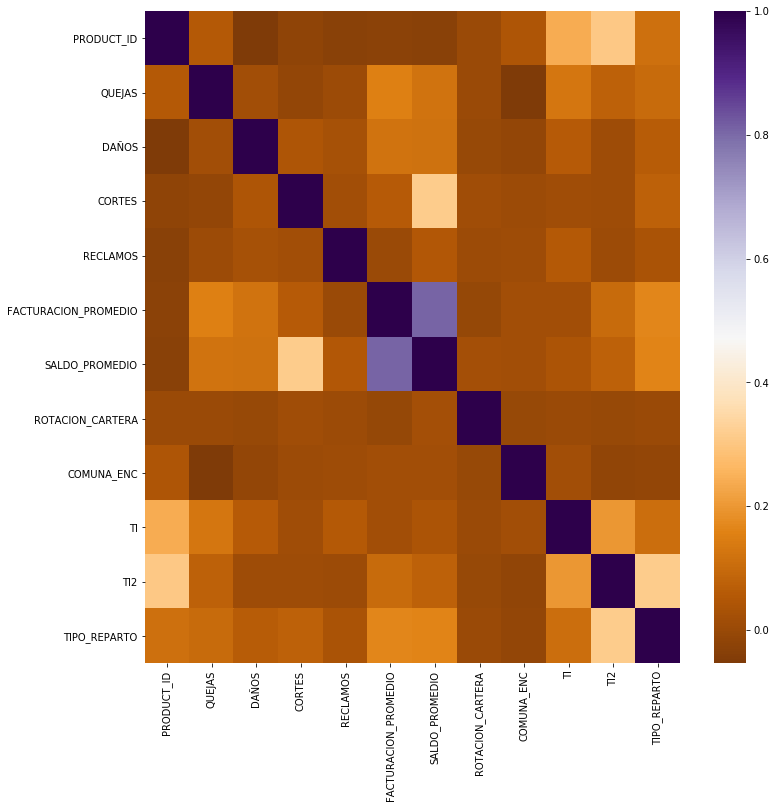

In [49]:
matrix_coor = sample[features].corr(method='pearson' ) #‘pearson’, ‘kendall’, ‘spearman’ 

#print(matrix_coor)
sns.heatmap(matrix_coor, cmap="PuOr") 

In [50]:
sample = sample[(sample.QUEJAS==9)]

In [51]:
sample[features].corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('PuOr'), axis=1)

,PRODUCT_ID,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC,TI,TI2,TIPO_REPARTO
PRODUCT_ID,1.0,nan,-0.092,-0.042,-0.12,-0.027,-0.025,-0.075,-0.09,nan,nan,-0.064
QUEJAS,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
DAÑOS,-0.092,nan,1.0,-0.0052,0.76,0.0025,0.014,0.0021,0.88,nan,nan,-0.39
CORTES,-0.042,nan,-0.0052,1.0,0.2,-0.078,-0.059,0.081,-0.0021,nan,nan,-0.072
RECLAMOS,-0.12,nan,0.76,0.2,1.0,-0.05,-0.04,0.05,0.87,nan,nan,-0.39
FACTURACION_PROMEDIO,-0.027,nan,0.0025,-0.078,-0.05,1.0,0.98,-0.078,-0.03,nan,nan,0.061
SALDO_PROMEDIO,-0.025,nan,0.014,-0.059,-0.04,0.98,1.0,-0.019,-0.031,nan,nan,0.061
ROTACION_CARTERA,-0.075,nan,0.0021,0.081,0.05,-0.078,-0.019,1.0,-0.0019,nan,nan,0.0037
COMUNA_ENC,-0.09,nan,0.88,-0.0021,0.87,-0.03,-0.031,-0.0019,1.0,nan,nan,-0.45
TI,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [52]:
#sns.pairplot(sample )
sample.shape

(1622, 12)

In [53]:
sample.describe()

,PRODUCT_ID,QUEJAS,DAÑOS,CORTES,RECLAMOS,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA,COMUNA_ENC,TI,TI2,TIPO_REPARTO
count,1622.000000,1622.0,1622.000000,1622.00000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.0,1622.0,1622.000000
mean,659579.463625,9.0,0.097411,0.01233,0.003699,115796.690860,118471.681018,1.110669,0.000617,1.0,1.0,0.996917
std,123322.097630,0.0,0.784099,0.14430,0.085960,87485.821588,88879.559433,1.477824,0.024830,0.0,0.0,0.055453
min,117201.000000,9.0,0.000000,0.00000,0.000000,240.272727,881.000000,0.381332,0.000000,1.0,1.0,0.000000
25%,661771.250000,9.0,0.000000,0.00000,0.000000,42579.672350,44962.022725,0.999981,0.000000,1.0,1.0,1.000000
50%,665231.000000,9.0,0.000000,0.00000,0.000000,105463.818000,108309.352500,0.999993,0.000000,1.0,1.0,1.000000
75%,714823.250000,9.0,0.000000,0.00000,0.000000,174181.393750,176291.824000,1.000510,0.000000,1.0,1.0,1.000000
max,952384.000000,9.0,28.000000,3.00000,3.000000,396632.545000,401482.364000,46.753163,1.000000,1.0,1.0,1.000000


In [54]:
# Distribucion de las comunas 
#dejar reclamos = 0 
#sacar quejas 
sample.groupby('TIPO_REPARTO').size().sort_values( ascending=False )

TIPO_REPARTO
1    1617
0       5
dtype: int64

In [55]:


## todo los datos  }
# VALIABLES POR SOBRE 0.1
#col_eliminadas = ['PRODUCT_ID'  , 'RECLAMOS', 'COMUNA_ENC' , 'ROTACION_CARTERA'   ]


# elimino la misca variable quejas ya que no es reprecentativa al tenener una magnitud
# se realiza un filter para variables irrelevantes
## quejas 9
col_eliminadas = ['PRODUCT_ID' ,'RECLAMOS', 'QUEJAS', 'COMUNA_ENC'  , 'TI' ,'TI2'  , 'TIPO_REPARTO' ]

# Elimino la comuna de concon (outlier) 99
sample = sample[sample.COMUNA_ENC == 0 ]
#col_eliminadas = ['PRODUCT_ID'  ] 

## 14 14141414
#dejar reclamos = 0 
#col_eliminadas = ['PRODUCT_ID' ,'RECLAMOS', 'QUEJAS', 'COMUNA_ENC', 'TI' ,'TI2'  ]
#sample= sample[sample.RECLAMOS == 0 ]
#sacar quejas 

# respaldo para hacer el join final
col_id = sample[['PRODUCT_ID']]

sample.drop(col_eliminadas, inplace=True, axis=1) 
col_id.shape

(1621, 1)

In [56]:
sample.describe(include='all')

,DAÑOS,CORTES,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA
count,1621.000000,1621.000000,1621.000000,1621.000000,1621.000000
mean,0.080197,0.012338,115862.834407,118539.474776,1.110737
std,0.366477,0.144344,87472.241013,88865.027222,1.478278
min,0.000000,0.000000,240.272727,881.000000,0.381332
25%,0.000000,0.000000,42608.416700,45046.090900,0.999981
50%,0.000000,0.000000,105503.000000,108362.455000,0.999993
75%,0.000000,0.000000,174223.636000,176340.182000,1.000511
max,7.000000,3.000000,396632.545000,401482.364000,46.753163


In [57]:

#col_id = sample[['PRODUCT_ID']]


In [58]:
#sns.heatmap(sample.corr(method='pearson' ), cmap="PiYG") 
## otro 
sample.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('PuOr'), axis=1)

,DAÑOS,CORTES,FACTURACION_PROMEDIO,SALDO_PROMEDIO,ROTACION_CARTERA
DAÑOS,1.0,-0.007,0.063,0.088,0.0079
CORTES,-0.007,1.0,-0.078,-0.059,0.081
FACTURACION_PROMEDIO,0.063,-0.078,1.0,0.98,-0.079
SALDO_PROMEDIO,0.088,-0.059,0.98,1.0,-0.019
ROTACION_CARTERA,0.0079,0.081,-0.079,-0.019,1.0


In [59]:
sample.columns

Index(['DAÑOS', 'CORTES', 'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO',
       'ROTACION_CARTERA'],
      dtype='object')

## Selección de variables 2

In [60]:
#columnas=['QUEJAS', 'DAÑOS',
#            'CORTES', 'RECLAMOS','FACTURACION_PROMEDIO',
#            'SALDO_PROMEDIO', 'ROTACION_CARTERA' ,
#           'COMUNA_ENC' , 'TI' , 'TI2' ,'TIPO_REPARTO' ]
#
##columnas=['DAÑOS' , 'RECLAMOS' ,'FACTURACION_PROMEDIO', 'SALDO_PROMEDIO','COMUNA_ENC']
#
##columnas=['FACTURACION_PROMEDIO', 'SALDO_PROMEDIO' ]
#
### seleccion para 9 quejas 
#columnas=[  'DAÑOS', 'CORTES'  ,'FACTURACION_PROMEDIO',
#            'SALDO_PROMEDIO', 'ROTACION_CARTERA'] 

## seleccion para 14
#columnas=[  'DAÑOS' ,'FACTURACION_PROMEDIO',
#            'SALDO_PROMEDIO', 'ROTACION_CARTERA'] 
#
#sample=sample[columnas].sample(frac=1, random_state=42)
#sample.shape

In [61]:
#fig = ploty_scatter( list(range(0 , len(sample['SALDO_PROMEDIO'])))  , sample['SALDO_PROMEDIO'])
#py.iplot(fig ,   filename='simple_scatter')  

In [62]:
# muestreo
#aux=sample
#sample =aux

In [63]:
#sample = sample[  (sample.QUEJAS==9)]
#sample = sample[(sample.QUEJAS==9) ]
#sample = sample[(sample.QUEJAS==14) | (sample.QUEJAS==9)]

sample.shape[0]

1621

##  Criterios de validación internos 

Se grafican los criterios de validación por medio de un grafico de diperción
Se evaluan los siguentes coeficientes 
- Silueta : Se ordena por este coeficinte todos los valores
- Calinki : Se buscan puntos mas altos 
- Bouldin : Se buscan valores más  bajos

Ademas se grafican los parametros para encontrar el numero optimo de clusters

- minpts : Numero de vecinos evaluado
- N° de clusters: Agrupaciones estimadas por el algoritmo

In [65]:
frac=1
sample = sample.sample(frac=frac , random_state=42)  # *3 hays lleagr a a 2337

In [66]:
sample.shape

(1621, 5)

## Test

In [67]:
# Genera un df con los resultados del test 
bench =[]
bench = test_silueta(sample)

1mpts:2 Silueta: 0.3
2mpts:3 Silueta: 0.24
3mpts:4 Silueta: 0.16
4mpts:5 Silueta: 0.17
5mpts:6 Silueta: 0.16
6mpts:7 Silueta: 0.17
7mpts:8 Silueta: 0.14
8mpts:9 Silueta: 0.17
9mpts:10 Silueta: 0.12
10mpts:11 Silueta: 0.09
11mpts:12 Silueta: 0.14
12mpts:13 Silueta: 0.13
13mpts:14 Silueta: 0.03
14mpts:15 Silueta: 0.09
15mpts:16 Silueta: 0.09
16mpts:17 Silueta: 0.09
17mpts:18 Silueta: 0.08
18mpts:19 Silueta: 0.08
19mpts:20 Silueta: 0.09
20mpts:21 Silueta: 0.06
21mpts:22 Silueta: 0.03
22mpts:23 Silueta: 0.02
23mpts:24 Silueta: 0.06
24mpts:25 Silueta: 0.06
25mpts:26 Silueta: 0.06
26mpts:27 Silueta: 0.04
27mpts:28 Silueta: 0.06
28mpts:29 Silueta: 0.03
29mpts:30 Silueta: 0.04
30mpts:31 Silueta: 0.03
31mpts:32 Silueta: 0.1
32mpts:33 Silueta: 0.04
33mpts:34 Silueta: 0.03
34mpts:35 Silueta: 0.07
35mpts:36 Silueta: 0.07
36mpts:37 Silueta: -0.0
37mpts:38 Silueta: -0.03
38mpts:39 Silueta: 0.03
39mpts:40 Silueta: -0.0
40mpts:41 Silueta: -0.06
41mpts:42 Silueta: 0.07
42mpts:43 Silueta: 0.02
43mpts:44

In [69]:
# ordena los valores por silueta num_vecinos num_clusters
bench = bench.sort_values('num_clusters' , ascending=False ) 

# asigna el nuevo indice para graficar los datos
bench = bench.reset_index(drop=True)
py.plot(plot_test(bench), filename='multiple-axes-multiple')

'https://plot.ly/~cachulooo/36'

In [68]:
# ordena los valores por silueta num_vecinos num_clusters
bench = bench.sort_values('silueta' , ascending=False ) 

# asigna el nuevo indice para graficar los datos
bench = bench.reset_index(drop=True)
py.plot(plot_test(bench), filename='multiple-axes-multiple')

'https://plot.ly/~cachulooo/36'

In [ ]:
sample.shape

## HDBSCAN

In [70]:
#aux = sample 

In [71]:
import hdbscan
 
mpts = 14

coef_s=0
coef_c=0
coef_b=0


X = np.array( sample )

#X = np.array(sample.to_records().view(type=np.matrix))

#X = sample.to_records().view(type=np.matrix)
#X = np.asarray(X)

registros = sample.shape[0]
# Estandarización
#scaler = StandardScaler().fit(X)
#X = scaler.transform(X)

clusterer = hdbscan.HDBSCAN(min_cluster_size=mpts  ).fit(X)   
labels_ = clusterer.labels_ 

#coef_s=metrics.silhouette_score( X , labels_ )
#coef_c=metrics.calinski_harabaz_score(X, labels_)
#coef_b=davies_bouldin_score(X, labels_)
   
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
sample['label']=labels_
n_clusters_

15

In [72]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = sample.index.values
cluster_map['cluster'] = labels_

In [73]:
 cluster_map = cluster_map.merge(col_id , left_on='data_index', right_on=col_id.index, how='left')[['data_index','cluster','PRODUCT_ID']]

In [74]:
 cluster_map.head()

,data_index,cluster,PRODUCT_ID
0,14446,5,664999
1,16604,5,714883
2,17889,11,725352
3,17858,5,723340
4,16019,-1,697831


In [75]:
final = cluster_map.merge(df , left_on='data_index', right_on=df.index, how='left')

In [79]:
final.to_csv('final.csv' , sep=";" , decimal="," , encoding='utf-8' ,   index=False  )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
import hdbscan

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 12)

plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

labels =labels_ 
end_time = time.time()
palette = sns.color_palette('deep', np.unique(labels).max() + 1)


In [ ]:
colors = [palette[x] if x >= 0 else ('#efefef') for x in labels]
plt.scatter(X.T[3], X.T[4], c=colors ,**plot_kwds )
frame = plt.gca()
frame.axes.get_xaxis().set_visible(True)
frame.axes.get_yaxis().set_visible(True)
plt.xlim(0 , 40000)
plt.ylim(0 , 60000) 

title='[Registros:'+str(registros)+']'+'[mpts:' +str(mpts)+']'+'[Clusters:' +str(n_clusters_)+']'+'[Silueta:'  +str(round(coef_s , 2))+']'+'[Calinski:' +str(round(coef_c , 2))+']'+'[Bouldin:'  +str(round(coef_b , 2))+']'
plt.title(title)
#plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [ ]:
#clusterer.single_linkage_tree_.plot()

In [ ]:
## correlograma
#sample.describe()
#sns.pairplot(sample , hue='label')

## Guardando resultados

In [ ]:
sample.head()

In [ ]:
col_id.head()

In [ ]:
#Asignacion de clusters  
col_id['label2']=sample.label

In [ ]:
#GUARDANDO RESULTADOS
col_id.to_csv('resultados.csv', sep=';' , index=False , decimal = ',')

In [ ]:
id_cluster = [(a, b) for (a, b) in zip(labels, col_id.PRODUCT_ID)]

In [ ]:
id_cluster 

# Gráficas

In [ ]:
sample.columns

In [77]:
fig = scatter(3,4)
py.iplot(fig ,   filename='scatter_hdbscan')

In [ ]:
fig = scatter(1,4)
py.iplot(fig ,   filename='scatter_hdbscan')

In [ ]:
sample.columns

In [78]:
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
## COORDENADAS PARALELAS 
data = [
    go.Parcoords(
        line = dict(color = labels_   ,
                    colorscale=colorscale   ,
                    #reversescale = True,
                    #showscale = True 
                   ) ,  
        dimensions = list([
            dict( #range = [0,8], 
                label = sample.columns[0] ,      values = X[:, 0]),
            dict( #range = [0,400000],
                label = sample.columns[1],       values = X[:, 1]),
            dict( #range = [0,400000],
                label = sample.columns[2],       values = X[:, 2]),
            dict( #range = [0,50000],
                label = sample.columns[3],       values = X[:, 3]),
            dict( #range = [0,50000], 
                label = sample.columns[4],       values = X[:, 4]), 
         #   dict( visible=False ,#range = [0,500000], 
         #       label = sample.columns[5],       values = X[:, 5]),   
         #   dict( visible=False ,#range = [0,3],
         #       label = sample.columns[6],       values = X[:, 6]),  
        #    dict( visible=False ,#range = [0,8],
        #        label = sample.columns[7],       values = X[:, 7]), 
         #  dict( #range = [0,8],
         #      label = sample.columns[8],        values = X[:, 8]), 
         #  dict( #range = [0,8],
         #      label = sample.columns[9],        values = X[:, 9]), 
         #  dict( #range = [0,8],
         #      label = sample.columns[10],        values = X[:, 10]),  
            dict( #range = [-1, n_clusters_-1 ],#   K CLUSTERS
                label = 'CLUSTER',                values = labels_) 
        ])
    )
]

layout = go.Layout(
    title='[Registros:'+str(registros)+']'+
          '[mpts:' +str(mpts)+']'+
          '[Clusters:' +str(n_clusters_)+']'+
          '[Silueta:'  +str(round(coef_s , 2))+']'+
          '[Calinski:' +str(round(coef_c , 2))+']'+
          '[Bouldin:'  +str(round(coef_b , 2))+']'
    ,

    plot_bgcolor = '#FFFFFF',
    paper_bgcolor = '#FFFFFF'
) 
fig = go.Figure(data = data, layout = layout)
py.iplot(fig, filename = 'hdbscan914'+str(registros))

In [ ]:
# Only test delete
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
#iplot([{"x": [1, 2, 3], "y": [3, 1, 6]}])

In [ ]:
fig = caja(sample['SALDO_PROMEDIO'])
py.iplot(fig ,   filename='caja') 

In [ ]:
len(sample.columns)

In [ ]:
np.unique(sample.label)

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)
plt.scatter( X.T[5] , X.T[6], s=60, linewidth=0, c=colors, alpha=1)
#plt.ylim(0.9,7)
#plt.xlim(0,1000000)
plt.xlabel('SALDO_PROMEDIO' ) #4
plt.ylabel('ROTACION_CARTERA') 
plt.title('HDBSCAN')

## Anexo 

In [ ]:
## Grid search
#Se ultiliza para optimizar los hiperparametros de un un modelo , vectorizando las entradas
from sklearn.metrics import silhouette_score as sc
from sklearn.model_selection import GridSearchCV
import hdbscan 
X = np.array(sample ) 


## parte 1 
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    
    #hdbscan = hdbscan.HDBSCAN(8).fit(X)
    cluster_labels = estimator.labels_
    num_labels = len(set(cluster_labels))
    #num_samples = len(X.index)
    num_samples = X.shape[0]
    if num_labels == 1 or num_labels == num_samples:
        return -1
    else:
        return sc(X, cluster_labels)
    
def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(X, clusters )
    return score
    
    
cv = [(slice(None), slice(None))] 
from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)

import hdbscan   
param_grid = {"min_cluster_size": list(range(2, 117))}
estimator=hdbscan.HDBSCAN().fit(X)
gs = GridSearchCV(estimator,
                  param_grid=param_grid, 
                  scoring=silhouette_score(estimator , X),
                  cv=cv, 
                  n_jobs=-1)

gs.fit(sample)


##### parte 2 
def silhouette_score(estimator, X):
    clusters = estimator.fit_predict(X)
    score = metrics.silhouette_score(sample, labels_, metric='precomputed')
    return score

ca = KMeans()
param_grid = {"n_clusters": range(2, 11)} 

param_dict ={}

from sklearn import preprocessing
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
# run randomized search
search = GridSearchCV(
    ca,
    param_grid=param_grid,
    n_iter=9,
    scoring=silhouette_score(ca, X),
    cv=cv 
    )
search.fit(sample)